In [9]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
import pdb
import matplotlib.pyplot as plt
import h5py    
import pandas as pd

#import sklearn


import seaborn as sns
print(sns.__version__)
#import plotly.express as px
from scipy.special import betaincinv
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


import astropy.units as u
from astropy.cosmology import Planck15  

0.12.2


In [10]:
data_path = "/Users/marchuertascompany/Documents/data/CEERS/DenseBasis/"
ceers_cat = pd.read_csv(data_path+"CEERS_DR05_adversarial_asinh_4filters_1122_4class_ensemble_v02_stellar_params_morphflag_delta_10points_DenseBasis_galfit_CLASS_STAR_v052_bug.csv")
#candels_ceers = pd.read_csv(data_path+"CANDELS_CEERS_match_DR05_december_ensemble_galfit_4filters_bug.csv")

#print('hello')

In [11]:





morph_flag=[]
delta_value = []

for sph,dk,irr,bd in zip(ceers_cat.sph_f356w_mean,ceers_cat.disk_f356w_mean,ceers_cat.irr_f356w_mean,ceers_cat.bd_f356w_mean):
    maxpos = np.argmax([sph,dk,irr,bd])
    delta = np.sort([sph,dk,irr,bd])[3]-np.sort([sph,dk,irr,bd])[2]
    morph_flag.append(maxpos)
    delta_value.append(delta)
    
#morph_flag=np.array(morph_flag)
#morph_flag[(ceers_cat.disk_f356>0.3)]=1
#morph_flag[(ceers_cat.irr_f356>0.3) & (ceers_cat.sph_f356>0.3)]=3
ceers_cat['morph_flag_f356w']=np.array(morph_flag)
ceers_cat['delta_f356']=np.array(delta_value)

morph_flag=[]
delta_value = []

for sph,dk,irr,bd in zip(ceers_cat.sph_f200w_mean,ceers_cat.disk_f200w_mean,ceers_cat.irr_f200w_mean,ceers_cat.bd_f200w_mean):
    maxpos = np.argmax([sph,dk,irr,bd])
    delta = np.sort([sph,dk,irr,bd])[3]-np.sort([sph,dk,irr,bd])[2]
    morph_flag.append(maxpos)
    delta_value.append(delta)
#morph_flag=np.array(morph_flag)
#morph_flag[(ceers_cat.disk_f200>0.3)]=1    
ceers_cat['morph_flag_f200w']=np.array(morph_flag)
ceers_cat['delta_f200']=np.array(delta_value)

morph_flag=[]
delta_value = []

for sph,dk,irr,bd in zip(ceers_cat.sph_f444w_mean,ceers_cat.disk_f444w_mean,ceers_cat.irr_f444w_mean,ceers_cat.bd_f444w_mean):
    maxpos = np.argmax([sph,dk,irr,bd])
    delta = np.sort([sph,dk,irr,bd])[3]-np.sort([sph,dk,irr,bd])[2]
    morph_flag.append(maxpos)
    delta_value.append(delta)
#morph_flag=np.array(morph_flag)
#morph_flag[(ceers_cat.disk_f200>0.3)]=1    
ceers_cat['morph_flag_f444w']=np.array(morph_flag)
ceers_cat['delta_f444']=np.array(delta_value)


morph_flag=[]
delta_value = []

for sph,dk,irr,bd in zip(ceers_cat.sph_f150w_mean,ceers_cat.disk_f150w_mean,ceers_cat.irr_f150w_mean,ceers_cat.bd_f150w_mean):
    maxpos = np.argmax([sph,dk,irr,bd])
    delta = np.sort([sph,dk,irr,bd])[3]-np.sort([sph,dk,irr,bd])[2]
    morph_flag.append(maxpos)
    delta_value.append(delta)
#morph_flag=np.array(morph_flag)
#morph_flag[(ceers_cat.disk_f200>0.3)]=1    
ceers_cat['morph_flag_f150w']=np.array(morph_flag)
ceers_cat['delta_f150']=np.array(delta_value)


logf200 = np.log10(ceers_cat['FLUX_200'].values)
logA = np.log10(ceers_cat['A_IMAGE'].values)
class_star = ceers_cat.CLASS_STAR_200

star_flag = logf200*0.0
delta_loc = logA-0.2*logf200+0.01
star_flag[delta_loc<0]=1
ceers_cat['star_flag']=star_flag

#ceers_cat.to_csv(data_path+"CEERS_DR05_adversarial_asinh_4filters_1122_4class_ensemble_v02_stellar_params_morphflag_delta_10points_DenseBasis_galfit_CLASS_STAR_v052_bug.csv")

In [12]:
def build_features(ceers_cat,zbin,node_features):
    x = node_features['x']   # halo mass and concentration
    t = node_features['t']  

    x_updated=[]
    t_updated=[]

    for x_data, t_data in zip(x,t):
        #print(x_data)

        sel2 = ceers_cat.query("F356W_RE > 0  and logM_50>7 and zfit_50>"+str(zbin[0])+" and zfit_50<"+str(zbin[1]))
        #print(len(sel2))
        for i in range(len(sel2)):
            
            # Append 'x_data' and 't_data' for the current galaxy in the second bin
            if (sel2.logM_50.values[i]-np.log10(2)-x_data[-1,0])>0. or (sel2.logM_50.values[i]-np.log10(2)-x_data[-1,0])<2:
                continue

            new_entry  = [sel2.logM_50.values[i]-np.log10(2),np.log10(0.8*Planck15.angular_diameter_distance(sel2.zfit_50.values[i]).value * np.deg2rad(sel2.F356W_RE.values[i] / 3600) * 1e3)]
            new_x = np.vstack([x_data, new_entry])

            new_entry = [1/(1+sel2.zfit_50.values[i]) ] 
            new_t = np.vstack([t_data,new_entry])
            #pdb.set_trace()

            # Convert the 'x_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
            cleaned_x_mass = [float(value) for value,size in zip(new_x[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_x_size = [float(value) for value in (new_x[0:,1]) if value != b'-' and value != b'-inf']
            x_copy = np.column_stack([cleaned_x_mass, cleaned_x_size])

            cleaned_t = [float(value) for value,size in zip(new_t[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_t = np.expand_dims(cleaned_t,1)

            x_updated.append(x_copy)
            t_updated.append(cleaned_t)

            #pdb.set_trace()

      # Store 'x_copy' and 't' data as lists of NumPy arrays in the 'node_features' dictionary
    node_features = {'x': [np.array(arr, dtype=np.float32) for arr in x_updated], 't': [np.array(arr, dtype=np.float32) for arr in t_updated]}
    return node_features, len(sel2)
           






def build_roots(ceers_cat,zbins=[0,.75,1.5]):
    


    sel = ceers_cat.query("F356W_RE > 0 and logM_50>9.5 and zfit_50>"+str(zbins[0])+" and zfit_50<"+str(zbins[1]))

    x = []
    t = []
    node_features = {'x': None, 't': None}
    for mass,z,re in zip(sel.logM_50,sel.zfit_50,sel.F356W_RE):

        x_data=np.zeros((2,2))
        t_data=np.zeros(2)
        x_data[0,0]=mass-np.log10(2)

        x_data[0,1]=0.8*Planck15.angular_diameter_distance(z).value * np.deg2rad(re / 3600) * 1e3
        t_data[0] = 1/(1+z)   

        sel2 =  ceers_cat.query("F356W_RE > 0  and logM_50>7 and zfit_50>"+str(zbins[1])+" and zfit_50<"+str(zbins[2]))
        
        for i in range(len(sel2)):

            # Append 'x_data' and 't_data' for the current galaxy in the second bin
            if (sel2.logM_50.values[i]-np.log10(2)-x_data[-1,0])>0. or (sel2.logM_50.values[i]-np.log10(2)-x_data[-1,0])<2:
                continue

            x_data[1,0]=sel2.logM_50.values[i]-np.log10(2)
            x_data[1,1]=0.8*Planck15.angular_diameter_distance(sel2.zfit_50.values[i]).value * np.deg2rad(sel2.F356W_RE.values[i] / 3600) * 1e3
            t_data[1]=1/(1+sel2.zfit_50.values[i])  

            # Convert the 'x_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
            cleaned_x_mass = [float(value) for value,size in zip(x_data[0:,0],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_x_size = [float(value) for value in (x_data[0:,1]) if value != b'-' and value != b'-inf']

            #print(np.array(cleaned_x_mass).shape)
            x_copy = np.column_stack([cleaned_x_mass, np.log10(cleaned_x_size)])
            #print(np.array(x_copy).shape)
            #cleaned_x = [float(value) for value in x_data[1:] if value != b'-' and value != b'-inf']
            # Convert the 't_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
            cleaned_t = [float(value) for value,size in zip(t_data[0:],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_t = np.expand_dims(cleaned_t,1)
            
            # Append the cleaned 'x' and 't' data to their respective lists
            x.append(x_copy)
            t.append(cleaned_t)





    # Store 'x_copy' and 't' data as lists of NumPy arrays in the 'node_features' dictionary
    node_features = {'x': [np.array(arr, dtype=np.float32) for arr in x], 't': [np.array(arr, dtype=np.float32) for arr in t]}
    return node_features,len(sel2)

    

In [13]:


def get_maxlike_descendant(l_numpy,node_features, chunk_size,step=1):

    x=node_features['x']
    t=node_features['t']
    # Calculate the number of chunks
    
    
    x_sel=[]
    t_sel=[]
    if step>1:
        l_numpy = l_numpy[1::step]
    num_chunks = len(l_numpy) // chunk_size    
    print(num_chunks)
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size
        chunk = l_numpy[start_idx:end_idx]

        # Find the maximum value and its position in the chunk
        max_value = np.max(chunk)
        max_position = np.argmax(chunk)

        x_sel.append(x[start_idx + max_position])
        t_sel.append(t[start_idx + max_position])
        
    node_features_updated = {'x': [np.array(arr, dtype=np.float32) for arr in x_sel], 't': [np.array(arr, dtype=np.float32) for arr in t_sel]}
    return node_features_updated

In [14]:
# Load the trained model from a checkpoint file
from florah.models.rnn_model.rnn_generator import DataModule 
checkpoint_path = "/Users/marchuertascompany/Documents/data/CEERS/TNG100/last.ckpt"  # Specify the path to your checkpoint file
loaded_model = DataModule.load_from_checkpoint(checkpoint_path,map_location='cpu')

# Set the model to evaluation mode (important if you have dropout or batch normalization layers)
loaded_model.eval()

DataModule(
  (model): RecurrentMAF(
    (embedding_net): Identity()
    (rnn): ModuleList(
      (0): GRU(4, 128, batch_first=True)
      (1-3): 3 x GRU(128, 128, batch_first=True)
    )
    (maf_blocks): Flow(
      (_transform): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0-3): 4 x CompositeTransform(
                (_transforms): ModuleList(
                  (0): MaskedAffineAutoregressiveTransform(
                    (autoregressive_net): MADE(
                      (initial_layer): MaskedLinear(in_features=2, out_features=128, bias=True)
                      (context_layer): Linear(in_features=128, out_features=128, bias=True)
                      (blocks): ModuleList(
                        (0-1): 2 x MaskedFeedforwardBlock(
                          (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                          (line

In [17]:
import torch
from typing import Optional, Tuple
from torch import Tensor
def log_likelihood_obs(
        model: torch.nn.Module, batch: Tuple[Tensor],
        to_numpy: bool = True,  batch_size: int = 4096
    ):
    """ Sample trees using Recurrent-MAF model
    Parameters
    ----------
    model: torch.nn.Module
        Recurrent model
    roots: np.ndarray
        Root features
    times: np.ndarray
        Time features
    to_numpy: bool
        Whether to convert to numpy
    device: Optional
        Device to use
    batch_size: int

    Returns
    -------
    x: Union[Tensor, np.ndarray]
        Sampled trees
    """

    device ='cpu'
    model = model.to(device)

    #seq_len = len(roots)+1
    #mask = np.expand_dims(np.zeros(seq_len),axis=0)
    #mask = np.zeros((1, seq_len), dtype=np.bool)
    #mask[:, :seq_len] = True
    #t = np.concatenate((times, t_obs),axis=1)

    #x_tensor = torch.from_numpy(roots.astype('float32'))
    #y_tensor = torch.from_numpy(obs.astype('float32'))
    #t_tensor = torch.from_numpy(t.astype('float32'))
    #seq_len_tensor = torch.tensor(seq_len, dtype=torch.int32)
    #mask_tensor = torch.from_numpy(mask)

    #tensor_tuple = (x_tensor, y_tensor, t_tensor, seq_len_tensor, mask_tensor)

    lp=model.log_prob(batch,return_context=False)

   
    return lp

In [18]:
redshifts = np.array([1.5,2,2.5,3,4,6])

node_features,chunk_size = build_roots(ceers_cat)
preprocessed_node_features = loaded_model.transform(node_features, fit=False)
l  = log_likelihood_obs(loaded_model,preprocessed_node_features)
l_numpy = l.detach().numpy()
node_features = get_maxlike_descendant(l.detach().numpy(),node_features,chunk_size)

step=2
for zmin,zmax in zip(redshifts[:-1],redshifts[1:]):
    
    node_features,chunk_size = build_features(ceers_cat,[zmin,zmax],node_features)
    preprocessed_node_features = loaded_model.transform(node_features, fit=False)
    l  = log_likelihood_obs(loaded_model,preprocessed_node_features)
    node_features = get_maxlike_descendant(l.detach().numpy(),node_features, chunk_size,step=step)
    step+=1
    



channel 2
(1438034, 1, 2)
here 1
done
247
channel 2
(863018, 2, 2)
here 1
done


: 

: 

In [ ]:
print(node_features)

(81, 8, 2)


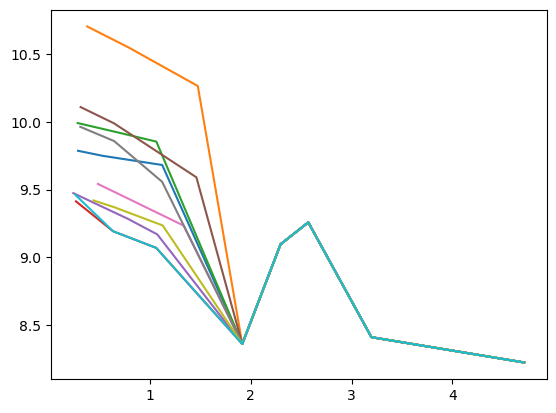

In [310]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(10):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,0]))

In [288]:
l_numpy = l_numpy[1::3]
print(l_numpy.shape)
print(chunk_size)

(94338,)
3494


In [289]:
print(283014/3494)

81.0


In [208]:
node_features_3,chunk_3 = build_features(ceers_cat,[1,1.5],node_features_new)

3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836
3836


In [237]:
x_r=node_features_3['x']
print(np.array(x_r).shape)
seq_len = np.array([len(x_r[i]) for i in range(len(x_r))])
print(np.max(seq_len))

(310716, 3, 2)
3


In [247]:
trees = node_features_3.get("x")
print(np.array(trees).shape)
x = [trees[i][:-1] for i in range(len(trees))]
print(np.array(x).shape)

(310716, 3, 2)
(310716, 2, 2)


In [253]:
preprocessed_node_features = loaded_model.transform(node_features_3, fit=False)
l  = log_likelihood_obs(loaded_model,preprocessed_node_features)


channel 2
(310716, 2, 2)
here 1
done


In [263]:
preprocessed_node_features[2].shape

torch.Size([310716, 3, 1])

In [249]:
l_numpy = l.detach().numpy()
print(l_numpy.shape)

(621432,)


In [267]:
print(l_numpy[3])

-355.26016


In [279]:
node_features_4 = get_maxlike_descendant(l.detach().numpy(),node_features_3, chunk_3,step=2)

81


In [280]:
node_features_4

{'x': [array([[9.78747   , 0.2811543 ],
         [9.75047   , 0.28208983],
         [9.68247   , 0.21246076]], dtype=float32),
  array([[10.70647   ,  0.19674468],
         [10.55047   ,  0.23703048],
         [10.26647   ,  0.3593926 ]], dtype=float32),
  array([[9.99247   , 0.37472704],
         [9.92947   , 0.4040387 ],
         [9.85547   , 0.41087183]], dtype=float32),
  array([[9.41347   , 0.8153198 ],
         [9.19247   , 0.70319307],
         [9.06947   , 0.66405463]], dtype=float32),
  array([[9.47447   , 0.36043763],
         [9.28547   , 0.4467122 ],
         [9.16947   , 0.44974905]], dtype=float32),
  array([[10.11047   , -0.03921846],
         [ 9.99047   , -0.10190435],
         [ 9.59147   ,  0.1425212 ]], dtype=float32),
  array([[9.54247   , 0.4050989 ],
         [9.43047   , 0.38865492],
         [9.23447   , 0.35454068]], dtype=float32),
  array([[ 9.96447   , -0.03102707],
         [ 9.85947   , -0.15078712],
         [ 9.55847   ,  0.21012981]], dtype=float32),
 

In [98]:
# in this case the nodes are the halo at each time step
x = node_features['x']   # halo mass and concentration
t = node_features['t']   # scale factor

print(np.array(t).shape)
print(np.array(x).shape)
print(x[4230][1])
print(len(sel2))
print(len(sel2)*len(sel))

(343845, 1, 1)
(343845, 2, 2)
[8.93147    0.11390261]
4245
343845


In [101]:
# Load the trained model from a checkpoint file
from florah.models.rnn_model.rnn_generator import DataModule 
checkpoint_path = "/Users/marchuertascompany/Documents/data/CEERS/TNG100/last.ckpt"  # Specify the path to your checkpoint file
loaded_model = DataModule.load_from_checkpoint(checkpoint_path,map_location='cpu')

# Set the model to evaluation mode (important if you have dropout or batch normalization layers)
loaded_model.eval()

DataModule(
  (model): RecurrentMAF(
    (embedding_net): Identity()
    (rnn): ModuleList(
      (0): GRU(4, 128, batch_first=True)
      (1-3): 3 x GRU(128, 128, batch_first=True)
    )
    (maf_blocks): Flow(
      (_transform): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0-3): 4 x CompositeTransform(
                (_transforms): ModuleList(
                  (0): MaskedAffineAutoregressiveTransform(
                    (autoregressive_net): MADE(
                      (initial_layer): MaskedLinear(in_features=2, out_features=128, bias=True)
                      (context_layer): Linear(in_features=128, out_features=128, bias=True)
                      (blocks): ModuleList(
                        (0-1): 2 x MaskedFeedforwardBlock(
                          (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                          (line

In [59]:
import torch
from typing import Optional, Tuple
from torch import Tensor
def log_likelihood_obs(
        model: torch.nn.Module, batch: Tuple[Tensor],
        to_numpy: bool = True,  batch_size: int = 4096
    ):
    """ Sample trees using Recurrent-MAF model
    Parameters
    ----------
    model: torch.nn.Module
        Recurrent model
    roots: np.ndarray
        Root features
    times: np.ndarray
        Time features
    to_numpy: bool
        Whether to convert to numpy
    device: Optional
        Device to use
    batch_size: int

    Returns
    -------
    x: Union[Tensor, np.ndarray]
        Sampled trees
    """

    device ='cpu'
    model = model.to(device)

    #seq_len = len(roots)+1
    #mask = np.expand_dims(np.zeros(seq_len),axis=0)
    #mask = np.zeros((1, seq_len), dtype=np.bool)
    #mask[:, :seq_len] = True
    #t = np.concatenate((times, t_obs),axis=1)

    #x_tensor = torch.from_numpy(roots.astype('float32'))
    #y_tensor = torch.from_numpy(obs.astype('float32'))
    #t_tensor = torch.from_numpy(t.astype('float32'))
    #seq_len_tensor = torch.tensor(seq_len, dtype=torch.int32)
    #mask_tensor = torch.from_numpy(mask)

    #tensor_tuple = (x_tensor, y_tensor, t_tensor, seq_len_tensor, mask_tensor)

    lp=model.log_prob(batch,return_context=False)

   
    return lp

In [102]:
preprocessed_node_features = loaded_model.transform(node_features, fit=False)
l  = log_likelihood_obs(loaded_model,preprocessed_node_features)

channel 2
(343845, 1, 2)
here 1
done


In [61]:
print(np.max(l.detach().numpy()))


6.5279903


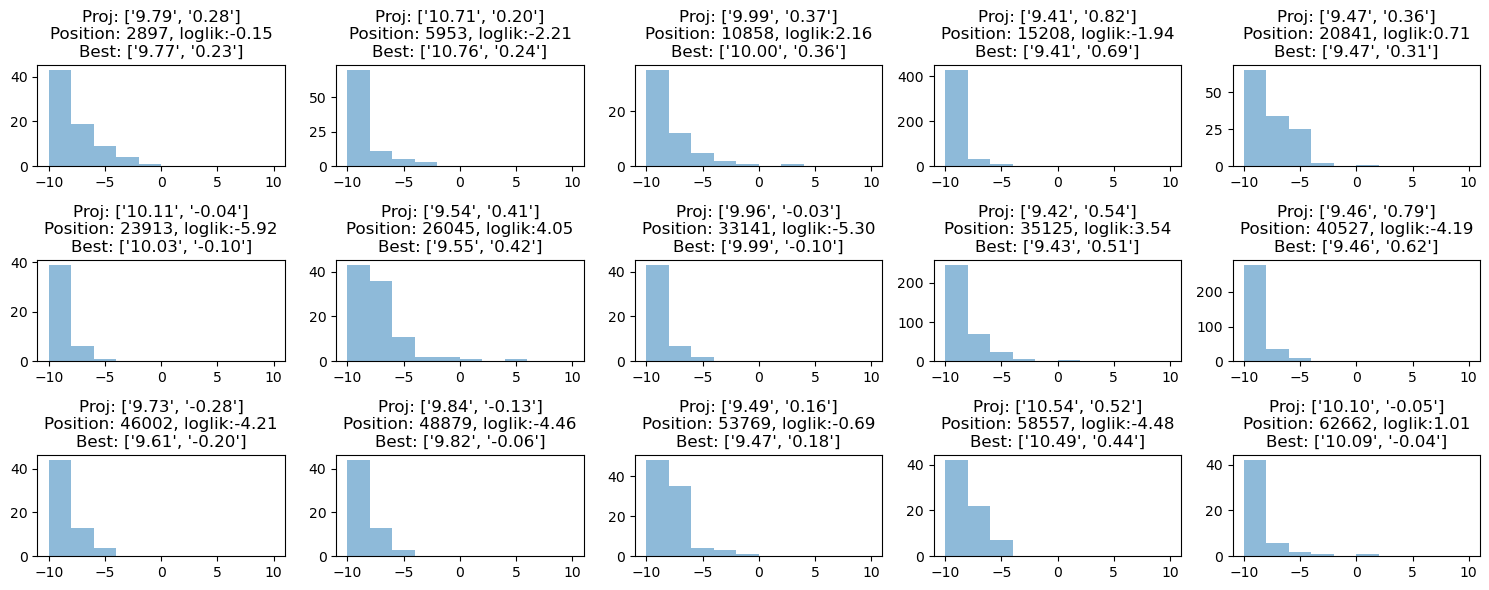

In [103]:

import matplotlib.pyplot as plt

l_numpy = l.detach().numpy()


# Assuming l_numpy is your 1D NumPy array
chunk_size = 4245

# Calculate the number of chunks
num_chunks = len(l_numpy) // chunk_size

# Create a figure with subplots for the first 10 chunks
fig, axes = plt.subplots(3, 5, figsize=(15, 6))  # 2 rows, 5 columns for 10 plots

# Iterate through the first 10 chunks and create individual histograms
for i, ax in enumerate(axes.flatten()):
    if i < num_chunks:
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size
        chunk = l_numpy[start_idx:end_idx]

        # Find the maximum value and its position in the chunk
        max_value = np.max(chunk)
        max_position = np.argmax(chunk)

        # Create a histogram for the chunk with a specified range
        ax.hist(chunk, bins=10, range=(-10, 10), alpha=0.5)
        x_values = [f'{value:.2f}' for value in x[start_idx + max_position][0]]
        best_values = [f'{value:.2f}' for value in x[start_idx + max_position][1]]
        ax.set_title(f'Proj: {x_values}\nPosition: {start_idx + max_position}, loglik:{(l_numpy[start_idx + max_position]):.2f}\nBest: {best_values}')

    else:
        # If there are fewer than 10 chunks, remove empty subplots
        fig.delaxes(ax)

# Adjust layout spacing
fig.tight_layout()

# Show the plots
plt.show()


